In [21]:
import csv
import cv2
import numpy as np
import os
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, Input
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

In [3]:
lines = []
with open('./sample_data/data/driving_log.csv') as file:
    file.readline()
    reader = csv.reader(file)
    for line in reader:
        lines.append(line)
        
train_lines, valida_lines = train_test_split(lines, test_size=0.2)
print('train: ', len(train_lines))
print('valida: ', len(valida_lines))

train:  6428
valida:  1608


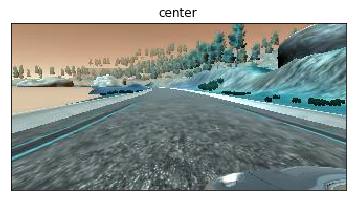

In [8]:
center_path = './sample_data/data/IMG/' + train_lines[0][0].split('/')[-1]
left_path = './sample_data/data/IMG/' + train_lines[0][1].split('/')[-1]
right_path = './sample_data/data/IMG/' + train_lines[0][2].split('/')[-1]
right = cv2.imread(left_path)
resize = cv2.resize(right, None, fx=0.25, fy=0.5)
rgb = cv2.cvtColor(resize, cv2.COLOR_BGR2RGB)

plt.imshow(right), plt.savefig('./left_bgr.jpg')
plt.title("center"), plt.xticks([]), plt.yticks([])
# plt.imshow(resize)
# plt.title("resize"), plt.xticks([]), plt.yticks([]), plt.savefig('./right_resize.jpg')
# plt.imshow(rgb)
# plt.title("rgb"), plt.xticks([]), plt.yticks([]), plt.savefig('./right_rgb.jpg')
plt.show()

In [13]:
def generator(samples, batch_size):
    ns = len(samples)
    while 1:
        samples = shuffle(samples)
        for offset in range(0, ns, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                center_path = './sample_data/data/IMG/' + sample[0].split('/')[-1]
                center_img = cv2.imread(center_path)
                center_img = cv2.resize(center_img, None, fx=0.25, fy=0.5)
                center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
                center_angle = float(line[3])
                images.append(center_img)
                angles.append(center_angle)
                images.append(cv2.flip(center_img, 1))
                angles.append(-center_angle)

                left_path = './sample_data/data/IMG/' + sample[1].split('/')[-1]
                left_img = cv2.imread(left_path)
                left_img = cv2.resize(left_img, None, fx=0.25, fy=0.5)
                left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
                left_angle = float(line[3]) + 0.20
                images.append(left_img)
                angles.append(left_angle)

                right_path = './sample_data/data/IMG/' + sample[2].split('/')[-1]
                right_img = cv2.imread(right_path)
                right_img = cv2.resize(right_img, None, fx=0.25, fy=0.5)
                right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
                right_angle = float(line[3]) - 0.25
                images.append(right_img)
                angles.append(right_angle)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)
            
train_generator = generator(train_lines, batch_size=128)
valida_generator = generator(valida_lines, batch_size=128)

In [17]:
# nvidia = Sequential()
# nvidia.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(80, 160, 3)))
# nvidia.add(Cropping2D(cropping=((35, 13), (0, 0))))
# nvidia.add(Convolution2D(24, 3, 3, subsample=(2, 2), activation='relu'))
# nvidia.add(Convolution2D(36, 3, 3, subsample=(2, 2), activation='relu'))
# nvidia.add(Convolution2D(48, 3, 3, activation='relu'))
# nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
# nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
# nvidia.add(Dropout(0.5))
# nvidia.add(Flatten())
# nvidia.add(Dense(100))
# nvidia.add(Dense(50))
# nvidia.add(Dense(10))
# nvidia.add(Dense(1))

In [52]:
nvidia = Sequential()
x = Input((80, 80, 3))
nvidia.add(Lambda(lambda x: x/127. - 1.0, input_shape=(80, 80, 3)))
lam = Lambda(lambda x: x/127. - 1.0)(x)
nvidia.add(Cropping2D(cropping=((35, 13), (0, 0))))
crop = Cropping2D(cropping=((35, 13), (0, 0)))(lam)
print(crop.shape)
nvidia.add(Convolution2D(24, 3, 3, subsample=(2, 2), activation='relu'))
conv1 = Convolution2D(24, 3, 3, subsample=(2, 2), activation='relu')(crop)
print(conv1.shape)
nvidia.add(Convolution2D(36, 3, 3, subsample=(2, 2), activation='relu'))
conv2 = Convolution2D(36, 3, 3, subsample=(2, 2), activation='relu')(conv1)
print(conv2.shape)
nvidia.add(Convolution2D(48, 3, 3,  activation='relu'))
conv3 = Convolution2D(48, 3, 3, activation='relu')(conv2)
print(conv3.shape)
nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
conv4 = Convolution2D(64, 3, 3, activation='relu')(conv3)
print(conv4.shape)
nvidia.add(Convolution2D(64, 3, 3, activation='relu'))
conv5 = Convolution2D(64, 3, 3, activation='relu')(conv4)
print(conv5.shape)
nvidia.add(Dropout(0.5))
nvidia.add(Flatten())
flat = Flatten()(conv5)
print(flat.shape)
nvidia.add(Dense(1000))
nvidia.add(Dense(100))
nvidia.add(Dense(50))
nvidia.add(Dense(10))
nvidia.add(Dense(1))

(?, 32, 80, 3)
(?, 15, 39, 24)
(?, 7, 19, 36)
(?, 5, 17, 48)
(?, 3, 15, 64)
(?, 1, 13, 64)
(?, ?)


In [15]:
# Hyperparameters
LEARNING_RATE = 1e-4
EPOCHS = 7

# Training
nvidia.compile(loss='mse', optimizer=Adam(LEARNING_RATE))
nvidia.fit_generator(train_generator, 
                     samples_per_epoch=len(4*train_lines),
                     validation_data=valida_generator, 
                     nb_val_samples=len(4*valida_lines), 
                     nb_epoch=EPOCHS)
nvidia.save('model.h5')

Epoch 1/7
26020/26020 [==============================] - 22s - loss: 0.0260 - val_loss: 0.0178
Epoch 2/7
26020/26020 [==============================] - 19s - loss: 0.0174 - val_loss: 0.0155
Epoch 3/7
26020/26020 [==============================] - 19s - loss: 0.0157 - val_loss: 0.0142
Epoch 4/7
26020/26020 [==============================] - 19s - loss: 0.0146 - val_loss: 0.0133
Epoch 5/7
26020/26020 [==============================] - 20s - loss: 0.0141 - val_loss: 0.0130
Epoch 6/7
26020/26020 [==============================] - 20s - loss: 0.0137 - val_loss: 0.0129
Epoch 7/7
26020/26020 [==============================] - 19s - loss: 0.0133 - val_loss: 0.0126
